In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '16'
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps
import random as rdm
# import multiprocessing
# from multiprocessing import pool
# from joblib import Parallel, delayed
# from mpi4py import MPI
# from functools import reduce
import time

# comm = MPI.COMM_WORLD
# rank = comm.rank
# size = comm.size

In [2]:
# start_time=time.time()
# #test script:
# a = np.random.randn(5000, 50000)
# b = np.random.randn(50000, 5000)
# ran_time=time.time()-start_time
# print("time to complete random matrix generation was %s seconds" % ran_time)
# np.dot(a, b) #this line should be multi-threaded
# print("time to complete dot was %s seconds" % (time.time() - start_time - ran_time))

# Generate POVMs

In [3]:
def generateM(povm):
    Ms = []
    if povm == '4Pauli':
        
        # Eigenvectors
        up = np.array([1+0j,0+0j], dtype='complex128')
        plus = np.array([1+0j,1+0j], dtype='complex128') / np.sqrt(2)
        right = np.array([1+0j,0+1j], dtype='complex128') / np.sqrt(2)
        
        # 4-Pauli POVMs for a single qubit
        M0 = np.outer(up, np.conj(up)) / 3
        M1 = np.outer(plus, np.conj(plus)) / 3
        M2 = np.outer(right, np.conj(right)) / 3
        M3 = np.eye(2, dtype='complex128') - M0 - M1 - M2
        
        Ms = [M0, M1, M2, M3]
        
    elif povm == 'Tetra':
        
        I = np.array([[1,0],[0,1]], dtype='complex128')
        X = np.array([[0, 1],[1, 0]], dtype='complex128')
        Z = np.array([[1, 0],[0, -1]], dtype='complex128')
        Y = np.array([[0, -1j],[1j, 0]], dtype='complex128')
        
        # Tetra
        v1 = np.array([0, 0, 1])
        M0 = (I + v1[0]*X + v1[1]*Y + v1[2]*Z)/4
        v2 = np.array([2*np.sqrt(2)/3, 0, -1/3])
        M1 = (I + v2[0]*X + v2[1]*Y + v2[2]*Z)/4
        v3 = np.array([-np.sqrt(2)/3, np.sqrt(2)/3, -1/3])
        M2 = (I + v3[0]*X + v3[1]*Y + v3[2]*Z)/4
        v4 = np.array([-np.sqrt(2)/3, -np.sqrt(2)/3, -1/3])
        M3 = (I + v4[0]*X + v4[1]*Y + v4[2]*Z)/4
        
        Ms = [M0, M1, M2, M3]
    elif povm == 'Pauli':
        
        def pXp(theta,phi):

            return np.array([[ np.cos(theta/2.0)**2, np.cos(theta/2.0)*np.sin(theta/2.0)*np.exp(-1j*phi)],\
                         [ np.cos(theta/2.0)*np.sin(theta/2.0)*np.exp(1j*phi), np.sin(theta/2.0)**2 ]])
        
        def mXm(theta,phi):

            return np.array([[ np.sin(theta/2.0)**2, -np.cos(theta/2.0)*np.sin(theta/2.0)*np.exp(-1j*phi)],\
                         [ -np.cos(theta/2.0)*np.sin(theta/2.0)*np.exp(1j*phi), np.cos(theta/2.0)**2 ]])
        
        Ps = np.array([1./3., 1./3., 1./3., 1./3.,1./3.,1./3.]);
        theta = np.pi/2.0
        M0 = Ps[0]*pXp(theta,0.0)
        M1 = Ps[1]*mXm(theta,0.0)
        M2 = Ps[2]*pXp(theta,np.pi/2.0)
        M3 = Ps[3]*mXm(theta,np.pi/2.0)
        M4 = Ps[4]*pXp(0.0,0.0)
        M5 = Ps[5]*mXm(0,0.0)
        
        Ms = [M0, M1, M2, M3, M4, M5]
        
    elif povm == 'Pauli_rebit':
        def pXp(theta,phi):

            return np.array([[ np.cos(theta/2.0)**2, np.cos(theta/2.0)*np.sin(theta/2.0)*np.exp(-1j*phi)],\
                         [ np.cos(theta/2.0)*np.sin(theta/2.0)*np.exp(1j*phi), np.sin(theta/2.0)**2 ]])
        
        def mXm(theta,phi):

            return np.array([[ np.sin(theta/2.0)**2, -np.cos(theta/2.0)*np.sin(theta/2.0)*np.exp(-1j*phi)],\
                         [ -np.cos(theta/2.0)*np.sin(theta/2.0)*np.exp(1j*phi), np.cos(theta/2.0)**2 ]])
        
        # pauli_rebit
        Ps = np.array([1./2., 1./2., 1./2., 1./2.])
        theta = np.pi/2.0
        M0 = Ps[0]*pXp(theta,0.0)
        M1 = Ps[1]*mXm(theta,0.0)
        M2 = Ps[2]*pXp(0.0,0.0)
        M3 = Ps[3]*mXm(0,0.0)
        
        Ms = [M0, M1, M2, M3]
    elif povm == 'Trine':
        
        I = np.array([[1,0],[0,1]], dtype='complex128')
        X = np.array([[0, 1],[1, 0]], dtype='complex128')
        Z = np.array([[1, 0],[0, -1]], dtype='complex128')
        Y = np.array([[0, -1j],[1j, 0]], dtype='complex128')
        
        # Trine
        phi0 = 0
        phi1 = 2*np.pi/3
        phi2 = 2*2*np.pi/3
        M0 = 0.5*(I + np.cos(phi0)*Z + np.sin(phi0)*X)*2/3.0
        M1 = 0.5*(I + np.cos(phi1)*Z + np.sin(phi1)*X)*2/3.0
        M2 = 0.5*(I + np.cos(phi2)*Z + np.sin(phi2)*X)*2/3.0
        
        Ms = [M0, M1, M2]
    elif povm == 'Psi2':
        M0 = np.array([[1,0],[0,0]], dtype='complex128')
        M1 = np.array([[0,0],[0,1]], dtype='complex128')
        Ms = [M0, M1]
    elif povm == 'test':
        M0 = np.array([[1,1j],[-1j,0]], dtype='complex128')
        M1 = np.array([[0,-1j],[1j,1]], dtype='complex128')
        Ms = [M0, M1]
    elif povm == 'test2':
        M0 = np.array([[1,1j],[-1j,0]], dtype='complex128')
        M1 = np.array([[0,-2j],[2j,0]], dtype='complex128')
        M2 = np.array([[0,1j],[-1j,1]], dtype='complex128')
        Ms = [M0, M1, M2]
    else:
        raise ValueError('POVM not defined.')
    return Ms

# training set
Our training set is a simple Gaussian distribution



Only need to change POVM and num_bit.

Parameters later will change automatically.

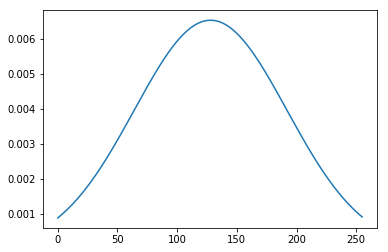

In [4]:
POVM = 'Tetra' # select from 4Pauli, Tetra, Pauli, Pauli_rebit, Trine, Psi2
Ms = generateM(POVM)
Mlist = Ms[:] # make a copy
num_M = len(Ms)

def gaussian_pdf(num_bit, mu, sigma):
    '''get gaussian distribution function'''
    x = np.arange(num_M**num_bit)     # changed to num_M
    pl = 1. / np.sqrt(2 * np.pi * sigma**2) * \
        np.exp(-(x - mu)**2 / (2. * sigma**2))
    return pl/pl.sum()


num_bit = 4
pg = gaussian_pdf(num_bit, mu=num_M**num_bit/2, sigma=num_M**(num_bit-1))  
plt.plot(pg)
plt.show()

# Tensorproduct of matrices

In [5]:
# make tensor product of POVMs
def tensorproduct(matrix1, matrix2):
    dim = matrix1.shape[0] * matrix2.shape[0]
    
    # has to reverse the order otherwise doesn't work
    return np.tensordot(matrix2, matrix1, axes = 0).swapaxes(1, 2).reshape(dim, dim)

In [6]:
for i in range(num_bit - 1):  # minus one because we initialized above
    Mlisttemp = []
    for m2 in Mlist:
        for m1 in Ms:
            Mlisttemp.append(tensorproduct(m1, m2))
    Mlist = Mlisttemp
# rdm.shuffle(Mlist)
Mlist[0].size

256

In [7]:
# # expectation value of POVMs, i.e. probabilities
# def probability(parameters):
#     wavefunction = gen_wavefunction(parameters)
#     problist = []
#     for m in Mlist:
#         problist.append(np.real(np.conj(wavefunction) @ m @ wavefunction)) # wf.H@M@wf
#         #problist.append(np.real(np.trace(np.outer(wavefunction, np.conj(wavefunction)@m)))) #trace(wf@wf.H@M)
#     return np.array(problist)

# expectation value of POVMs, i.e. probabilities
def probability(parameters):
    densitymatrix = gen_densitymatrix(parameters)
    problist = []
    for m in Mlist:
        problist.append(np.real(np.trace(densitymatrix@m))) #trace(p@M)
    return np.array(problist)

# Density Matrix

In [8]:
# def gen_wavefunction(parameters):
#     length = parameters.size
#     real = parameters[:length//2]
#     imaginary = parameters[length//2:]
#     combined = real + 1j * imaginary
#     return combined / np.linalg.norm(combined)
def gen_densitymatrix(parameters): # input should be a 1d array of correct length
    # convert 1d array to 2d square matrix
    length = int(round(np.sqrt(parameters.size)))
    matrix = parameters.reshape(length, length)
    # extract upper trangle (excluding diagonal)
    upper = np.triu(matrix, k=1)
    # extract lower trangle (excluding diagonal)
    lower = np.tril(matrix, k=-1)
    # extract diagonal
    diagnal = np.diag(matrix)
    # sum of diagonal (trace) should be 1
    diagnal = diagnal / diagnal.sum()
    # take the upper triangle and diagonal as the real part of the matrix
    real = upper + upper.T + np.diag(diagnal)
    # take the lower tirangle as the imaginary part of the matrix
    imaginary = 1j * lower - 1j * lower.T
    return real + imaginary

# MMD Loss Function
As a reminder
\begin{align}
    \mathcal{L} =&  \left\|\sum_{x} p_\theta(x) \phi(x)- \sum_{x} \pi(x) \phi(x)  \right\|^2 \\
    =&\langle K(x,y)\rangle_{x\sim p_\theta, y\sim p_\theta}-2\langle K(x,y)\rangle_{x\sim p_\theta,y\sim \pi}+\langle K(x, y)\rangle_{x\sim \pi,y\sim \pi}
\end{align}


In [9]:
class RBFMMD2(object):
    '''
    MMD^2 with RBF (Gaussian) kernel.
    
    Args:
        sigma_list (list): a list of bandwidths.
        basis (1darray): defininng space.
      
    Attributes:
        K (2darray): full kernel matrix, notice the Hilbert is countable.
    '''
    def __init__(self, sigma_list, basis):
        self.sigma_list = sigma_list
        self.basis = basis
        self.K = mix_rbf_kernel(basis, basis, self.sigma_list)

    def __call__(self, px, py):
        '''
        Args:
            px (1darray, default=None): probability for data set x, used only when self.is_exact==True.
            py (1darray, default=None): same as px, but for data set y.

        Returns:
            float: loss.
        '''
        pxy = px-py
        return self.kernel_expect(pxy, pxy)

    def kernel_expect(self, px, py):
        '''
        expectation value of kernel function.
        
        Args:
            px (1darray): the first PDF.
            py (1darray): the second PDF.
            
        Returns:
            float: kernel expectation.
        '''
        #return px.dot(self.K).dot(py)
        return px.dot(py)

def mix_rbf_kernel(x, y, sigma_list):
    '''
    multi-RBF kernel.
    
    Args:
        x (1darray|2darray): the collection of samples A.
        x (1darray|2darray): the collection of samples B.
        sigma_list (list): a list of bandwidths.
        
    Returns:
        2darray: kernel matrix.
    '''
    ndim = x.ndim
    if ndim == 1:
        exponent = np.abs(x[:, None] - y[None, :])**2
    elif ndim == 2:
        exponent = ((x[:, None, :] - y[None, :, :])**2).sum(axis=2)
    else:
        raise
    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma)
        K = K + np.exp(-gamma * exponent)
    return K

In [10]:
hndim = num_M**num_bit
# mmd loss
mmd = RBFMMD2(sigma_list=[0.25,4], basis=np.arange(num_M**num_bit))   # changed to num_M

# when exact match, MMD loss should be 0, e.g. two gaussians
print('Exact Match -> MMD = %.4f'%mmd(pg, pg))
# when not match, loss is not zero
prand = np.random.random(len(pg))
print('Not Match -> MMD = %.4f'%mmd(prand/prand.sum(), pg))

Exact Match -> MMD = 0.0000
Not Match -> MMD = 0.0023


In [11]:
def mmd_loss(parameters):
    return mmd(pg, probability(parameters))

256
(1+0j)


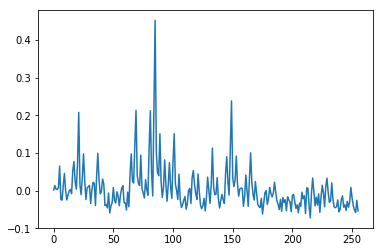

MMD loss for Initial Circuit = 0.8449


1.0000000000000004

In [12]:
#theta_list = np.random.random(2*2**num_bit)
theta_list = np.random.random(2**(2*num_bit)) # parameter list
print(theta_list.size)
print(np.trace(gen_densitymatrix(theta_list)))
p = probability(theta_list)
plt.plot(p)
plt.show()
print('MMD loss for Initial Circuit = %.4f'%mmd_loss(theta_list))
p.sum()

# Training
In this basic introduction, I prepaired classical training method like `Adam` and `L-BFGS-B` (as well as other methods supported by scipy).

In [13]:
  def train(theta_list, method, max_iter=1000, step_rate=0.1):
        
    step = [0]
    def callback(x, *args, **kwargs):
        step[0] += 1
        print('step = %d, loss = %s'%(step[0], mmd_loss(x)))
        
    theta_list = np.array(theta_list)
#     if method == 'Adam':
#         try:
#             from climin import Adam
#         except:
#             !pip install git+https://github.com/BRML/climin.git
#             from climin import Adam
#         optimizer = Adam(wrt=theta_list, fprime=bm.gradient,step_rate=step_rate)
#         for info in optimizer:
#             callback(theta_list)
#             if step[0] == max_iter:
#                 break
#         return bm.mmd_loss(theta_list), theta_list
#     else:
    from scipy.optimize import minimize
    res = minimize(mmd_loss, x0=theta_list,
                       method=method, jac = '2-point', tol=1e-15, # was -12
                       options={'maxiter': max_iter, 'disp': 0, 'gtol':1e-15, 'ftol':0}, # was -10
                       callback=callback,
                       )
    return res.fun, res.x

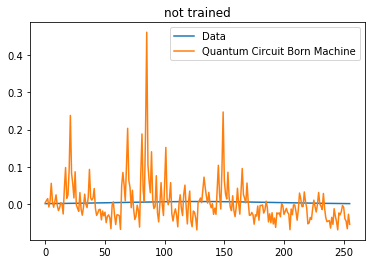

array([[4.28181763e-01, 7.07586520e-02, 1.08398981e-01, 4.64336888e-01,
        6.40378121e-01, 8.31485054e-01, 4.69517308e-01, 3.57683336e-01,
        7.59282005e-01, 4.18342941e-01, 7.67955926e-01, 4.42610021e-01,
        3.85902665e-01, 9.12267537e-03, 8.92683534e-01, 9.29185658e-01],
       [3.83288798e-01, 7.47684941e-01, 2.70216707e-02, 3.04332178e-01,
        1.30908214e-01, 7.07375035e-01, 9.24124726e-03, 7.09230495e-01,
        7.68785465e-01, 6.81115480e-01, 5.86080686e-01, 3.66145479e-01,
        4.42151810e-01, 2.84131653e-01, 4.62569399e-01, 7.51609561e-01],
       [2.92726716e-01, 2.80291077e-01, 7.94876458e-03, 5.77986530e-01,
        9.85333796e-01, 9.85492389e-01, 3.34784979e-01, 7.23502654e-01,
        8.57370029e-01, 1.38364741e-01, 5.24200227e-02, 6.55319389e-01,
        6.69828059e-01, 8.01678831e-01, 2.99004630e-01, 8.46126374e-01],
       [1.51891039e-01, 8.59041817e-02, 2.90317802e-01, 5.30137109e-01,
        4.94266042e-01, 8.16034406e-01, 3.36254791e-01, 9.626

In [14]:
# random initial parameter
theta_list = np.random.random((2**num_bit, 2**num_bit))
pl = probability(theta_list)
plt.plot(pg)
plt.plot(pl)
plt.legend(['Data', 'Quantum Circuit Born Machine'])
plt.title('not trained')
plt.show()
theta_list

step = 1, loss = 7.67513335621288e-06
step = 2, loss = 7.535107763985572e-06
step = 3, loss = 7.403460308946822e-06
step = 4, loss = 6.628628504485486e-06
step = 5, loss = 5.896205933713434e-06
step = 6, loss = 4.295104444699665e-06
step = 7, loss = 2.7228894050011386e-06
step = 8, loss = 2.1684159634695576e-06
step = 9, loss = 2.0691878292875366e-06
step = 10, loss = 1.7615321812008541e-06
step = 11, loss = 1.571527276401098e-06
step = 12, loss = 1.0839688280233003e-06
step = 13, loss = 9.395469108318643e-07
step = 14, loss = 9.107821209477606e-07
step = 15, loss = 8.641953744258793e-07
step = 16, loss = 8.406442929423366e-07
step = 17, loss = 7.230542847006405e-07
step = 18, loss = 5.706441568907899e-07
step = 19, loss = 3.900618975468586e-07
step = 20, loss = 3.6165459344984305e-07
step = 21, loss = 2.9188002985914625e-07
step = 22, loss = 2.77014154942769e-07
step = 23, loss = 2.623693023210955e-07
step = 24, loss = 2.451608558122092e-07
step = 25, loss = 2.1808566983807333e-07
ste

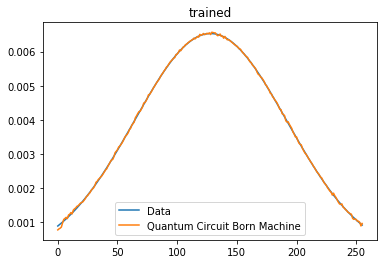

array([ 1.08794398e-01, -4.13193070e-04, -2.20437657e-03,  4.81964666e-04,
       -1.29070008e-02, -7.64255972e-04,  7.09405671e-04,  6.41405325e-04,
       -1.45372998e-02, -3.42713395e-04, -1.73114554e-03,  1.66841687e-03,
       -1.99576813e-02,  2.97402016e-03,  3.37367249e-03,  2.64381186e-03,
       -5.52697183e-04,  1.20481940e-01, -4.19870099e-04, -2.36038892e-03,
        1.05093319e-03, -1.34314816e-02,  2.13589010e-03, -3.17958370e-04,
       -2.01253845e-03, -1.13498422e-02, -1.23834749e-03, -1.62509152e-03,
       -9.66560846e-04, -2.10005975e-02, -5.50823249e-03,  3.73782328e-03,
       -2.36931311e-03,  6.00589136e-09,  1.79853652e-01, -5.90204260e-04,
        4.91716468e-04, -1.59429766e-03, -1.48314855e-02,  6.92537141e-04,
       -7.72777525e-03,  3.80979796e-04, -1.47738358e-03, -3.92679199e-04,
       -3.48010165e-03, -7.94245349e-03, -2.27273400e-02, -1.14897563e-03,
        1.12315643e-04, -2.47868072e-03, -6.33942898e-04,  2.18223653e-01,
       -1.23695337e-03,  

In [19]:
loss, theta_list = train(theta_list, 'L-BFGS-B', max_iter=30)

# display training result
plt.plot(pg)
plt.plot(probability(theta_list))
plt.legend(['Data', 'Quantum Circuit Born Machine'])
plt.title('trained')
plt.show()
theta_list

In [20]:
gen_densitymatrix(theta_list)

array([[ 1.23107582e-02+0.00000000e+00j, -4.13193070e-04+5.52697183e-04j,
        -2.20437657e-03+2.36931311e-03j,  4.81964666e-04-1.12315643e-04j,
        -1.29070008e-02+1.47566518e-02j, -7.64255972e-04-3.71685658e-04j,
         7.09405671e-04-1.07653375e-03j,  6.41405325e-04+6.03712196e-04j,
        -1.45372998e-02-4.35570791e-02j, -3.42713395e-04+2.28184611e-03j,
        -1.73114554e-03+8.33207155e-03j,  1.66841687e-03+1.80005913e-03j,
        -1.99576813e-02+1.89240332e-02j,  2.97402016e-03+1.67436315e-03j,
         3.37367249e-03-2.12220047e-03j,  2.64381186e-03+4.88431749e-03j],
       [-4.13193070e-04-5.52697183e-04j,  1.36332759e-02+0.00000000e+00j,
        -4.19870099e-04-6.00589136e-09j, -2.36038892e-03+2.47868072e-03j,
         1.05093319e-03+1.03492315e-04j, -1.34314816e-02+1.52765815e-02j,
         2.13589010e-03-5.67698973e-04j, -3.17958370e-04-8.79844791e-04j,
        -2.01253845e-03-1.20118541e-04j, -1.13498422e-02-4.66023186e-02j,
        -1.23834749e-03-1.64953644e-0

In [21]:
np.trace(gen_densitymatrix(theta_list)@gen_densitymatrix(theta_list))

(0.1677081765101029+0j)

In [22]:
np.linalg.eigh(gen_densitymatrix(theta_list))

(array([-0.03422911, -0.03031856, -0.02702183, -0.0237771 , -0.01122139,
        -0.00915523, -0.00466489, -0.0006298 ,  0.12271072,  0.12794892,
         0.13315201,  0.14004265,  0.14766699,  0.15232048,  0.15611473,
         0.16106142]),
 array([[ 0.2049849 +0.00000000e+00j, -0.34300719+0.00000000e+00j,
          0.19691163+0.00000000e+00j, -0.15737686+0.00000000e+00j,
         -0.55734496+0.00000000e+00j, -0.22238563+0.00000000e+00j,
          0.41385274+0.00000000e+00j, -0.27175592+0.00000000e+00j,
         -0.15286715+0.00000000e+00j, -0.20204124+0.00000000e+00j,
         -0.15764813+0.00000000e+00j, -0.18180151+0.00000000e+00j,
         -0.06977511+0.00000000e+00j, -0.09350711+0.00000000e+00j,
          0.15505227+0.00000000e+00j, -0.1087398 +0.00000000e+00j],
        [ 0.37411561-3.83928861e-02j,  0.17747684-7.74954217e-02j,
         -0.12328414-1.83509289e-01j,  0.04347461-2.17259769e-01j,
         -0.12231877-1.37679338e-01j,  0.34097567+3.32502417e-01j,
         -0.24007587